# Advanced PCOS Prediction Model

In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pandas.plotting import parallel_coordinates


## Data Cleaning

In [287]:
# Load Dataset

df = pd.read_excel("PCOS_data_without_infertility.xlsx", sheet_name="Full_new")

# Replace non-numeric placeholders with NaN
df = df.replace(["#NAME?", "NA", "N/A", " ", ""], np.nan)

# Clean Column Names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r'\s+', '_', regex=True)
              .str.replace(r'\(|\)', '', regex=True)
              .str.replace(r'[-./]', '_', regex=True)
)

# Define clinically relevant features
feature_cols = [
    'age_yrs',

    # Lifestyle & symptoms
    'weight_gainy_n', 'hair_growthy_n', 'skin_darkening_y_n',
    'hair_lossy_n', 'pimplesy_n', 'fast_food_y_n', 'reg_exercisey_n',

    # Hormones
    'fshmiu_ml', 'lhmiu_ml', 'prlng_ml', 'tsh_miu_l', 'prgng_ml', 

    # Infertility
    'amhng_ml','i_beta_hcgmiu_ml', 'ii_beta_hcgmiu_ml'
]

target_col = 'pcos_y_n'

# Confirm features exist
available_cols = [c for c in feature_cols if c in df.columns]
missing_cols = [c for c in feature_cols if c not in df.columns]
print("Missing columns:", missing_cols)

df_model = df[available_cols + [target_col]].copy()

# Convert continuous -> numeric
continuous_cols = [
    'age_yrs',
    'fshmiu_ml',
    'lhmiu_ml',
    'prlng_ml',
    'tsh_miu_l',
    'prgng_ml',
    'amhng_ml',
    'i_beta_hcgmiu_ml',
    'ii_beta_hcgmiu_ml'
]

for col in continuous_cols:
    if col in df_model.columns:
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

# Convert binary -> int64
binary_cols = [
    'weight_gainy_n', 'hair_growthy_n', 'skin_darkening_y_n',
    'hair_lossy_n', 'pimplesy_n', 'fast_food_y_n', 'reg_exercisey_n',
    'pcos_y_n'
]

for col in binary_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype("Int64")

# Handle missing values properly

# Check % missing
missing_pct = df_model.isna().mean().sort_values(ascending=False)
print("Missing percent:\n", missing_pct)

# Median impute continuous
for col in continuous_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(df_model[col].median())

# Mode impute binary
for col in binary_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].fillna(df_model[col].mode()[0])

# Fix skewed variables before clustering
skewed = ['amhng_ml', 'i_beta_hcgmiu_ml', 'ii_beta_hcgmiu_ml']

for col in skewed:
    if col in df_model.columns:
        df_model[col] = np.log1p(df_model[col].astype(float))


# Scale continuous variables
scaler = StandardScaler()
df_model_scaled = df_model.copy()

df_model_scaled[continuous_cols] = scaler.fit_transform(df_model[continuous_cols])

# Final X and y
X = df_model_scaled[feature_cols]
y = df_model_scaled[target_col]

print("Final shape:", X.shape)
X.head()


Missing columns: []
Missing percent:
 fast_food_y_n         0.001848
amhng_ml              0.001848
ii_beta_hcgmiu_ml     0.001848
age_yrs               0.000000
weight_gainy_n        0.000000
hair_lossy_n          0.000000
pimplesy_n            0.000000
skin_darkening_y_n    0.000000
hair_growthy_n        0.000000
fshmiu_ml             0.000000
reg_exercisey_n       0.000000
lhmiu_ml              0.000000
prlng_ml              0.000000
prgng_ml              0.000000
tsh_miu_l             0.000000
i_beta_hcgmiu_ml      0.000000
pcos_y_n              0.000000
dtype: float64
Final shape: (541, 16)


,age_yrs,weight_gainy_n,hair_growthy_n,skin_darkening_y_n,hair_lossy_n,pimplesy_n,fast_food_y_n,reg_exercisey_n,fshmiu_ml,lhmiu_ml,prlng_ml,tsh_miu_l,prgng_ml,amhng_ml,i_beta_hcgmiu_ml,ii_beta_hcgmiu_ml
0,-0.634606,0,0,0,0,0,1,0,-0.030679,-0.032219,1.393269,-0.613338,-0.010760,-0.682409,-1.005642,-0.690814
1,0.845230,0,0,0,0,0,0,0,-0.036306,-0.062129,-0.282919,0.047632,0.094356,-0.950795,0.241375,-0.690814
2,0.290291,0,0,0,1,1,1,0,-0.041794,-0.064554,-0.922773,-0.117610,-0.065946,0.580614,1.098137,1.743967
3,1.030210,0,0,0,0,0,0,0,-0.030172,-0.047462,0.841003,3.579026,-0.065946,-1.132134,-1.005642,-0.690814
4,-1.189545,0,0,0,1,0,0,0,-0.048989,-0.064323,0.385684,0.156906,-0.060690,-0.599101,1.296988,1.974105


## K-Means Clustering

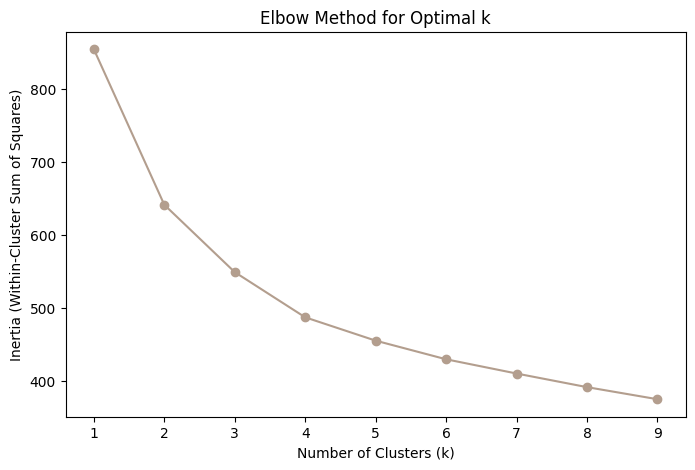

In [288]:
# Elbow Method

# Use only binary symptom/lifestyle features for clustering
binary_features = [col for col in binary_cols if col != target_col]
X_binary = df_model_scaled[binary_features]

inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_binary)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o', color="#B39E8E")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.show()


In [289]:
# Fit K-Means with chosen k
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_binary)

df_clustered = df_model.copy()
df_clustered["cluster"] = clusters
df_clustered["cluster"].value_counts()

cluster
1    322
0    219
Name: count, dtype: int64

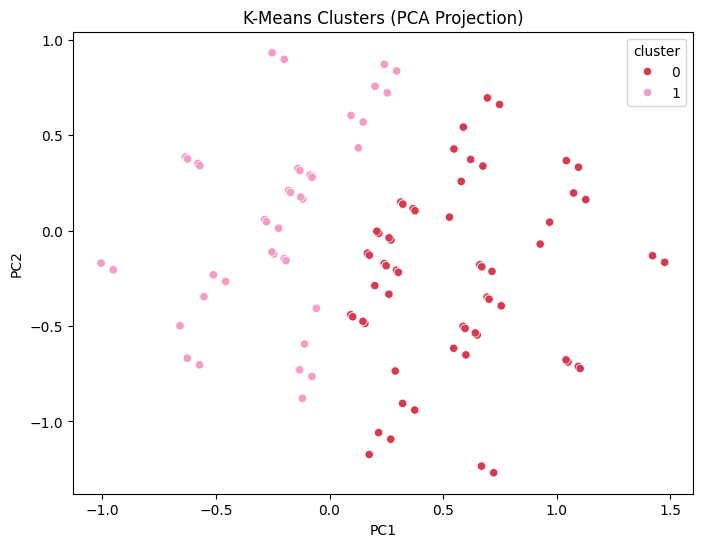

In [290]:
# PCA for Visualizing Clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_binary)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_components[:,0], 
    y=pca_components[:,1],
    hue=df_clustered["cluster"],
    palette=["#D53B50", "#F49CC5"]
)
plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## Distribution of Physical Symptoms Between Clusters

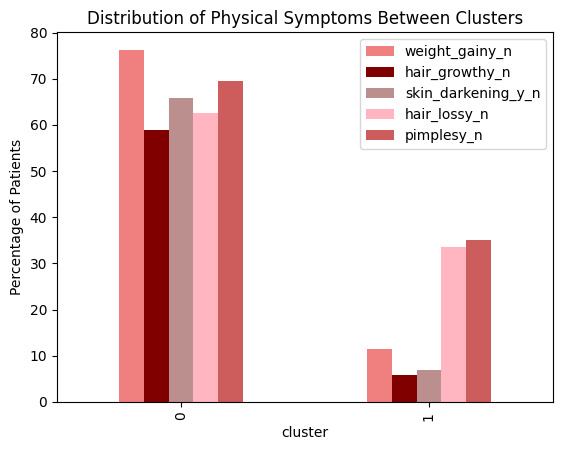

In [291]:
# Select physical symptoms
symptom_features = ['weight_gainy_n','hair_growthy_n','skin_darkening_y_n','hair_lossy_n','pimplesy_n']

# Group by symptoms by cluster
df_symptoms = df_clustered.groupby('cluster')[symptom_features].mean() * 100

# Plot
df_symptoms.plot(kind='bar',color=['lightcoral', 'maroon', 'rosybrown', 'lightpink', 'indianred'])
plt.ylabel("Percentage of Patients")
plt.title("Distribution of Physical Symptoms Between Clusters")
plt.show()


## Distribution of Lifestyle Choices Between Clusters

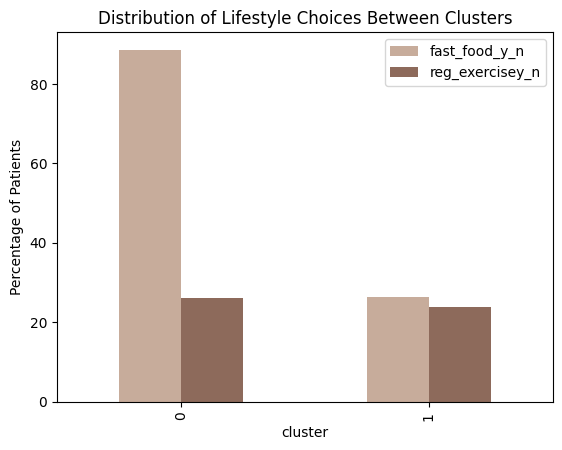

In [292]:
# Select lifestyle choices
lifestyle_features = ['fast_food_y_n', 'reg_exercisey_n']

# Group choices by cluster
df_percent = df_clustered.groupby('cluster')[lifestyle_features].mean() * 100

# Plot
df_percent.plot(kind='bar', color=["#C7AC9B", "#8D6A5B"])
plt.ylabel("Percentage of Patients")
plt.title("Distribution of Lifestyle Choices Between Clusters")
plt.show()

## Distribution of Age Groups Between Clusters

C:\Users\adrie\AppData\Local\Temp\ipykernel_12820\1926654152.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['cluster', 'age_group'])


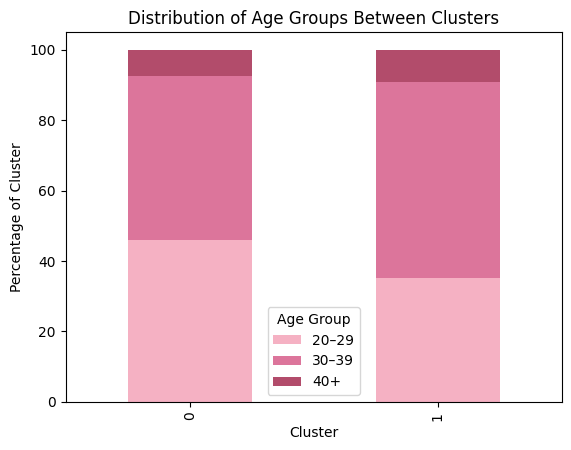

In [293]:
# Create age groups
age_bins = [20, 30, 40, 50]
df_clustered['age_group'] = pd.cut(
    df_clustered['age_yrs'],
    bins=age_bins,
    labels=['20–29', '30–39', '40+'],
    right=False
)

# Group by cluster and age group
age_cluster_counts = (
    df_clustered
    .groupby(['cluster', 'age_group'])
    .size()
    .unstack(fill_value=0)
)

# Convert counts to percentages within each cluster
age_cluster_pct = age_cluster_counts.div(
    age_cluster_counts.sum(axis=1),
    axis=0
) * 100

# Plot
age_cluster_pct.plot(kind='bar', stacked=True, color=["#F5B1C3", "#DC759B", "#B24C6B"])
plt.title("Distribution of Age Groups Between Clusters")
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")
plt.legend(title="Age Group")
plt.show()

## Distribution of PCOS Diagnosis Between Clusters

pcos_y_n          0          1
cluster                       
0         35.159817  64.840183
1         89.130435  10.869565


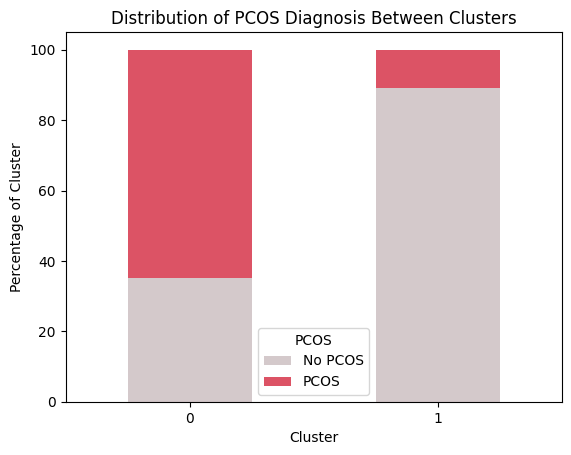

In [294]:
# Calculate counts of PCOS diagnosis per cluster
pcos_counts = df_clustered.groupby(['cluster', 'pcos_y_n']).size().unstack(fill_value=0)

# Convert counts to percentages within each cluster
pcos_percent = pcos_counts.div(pcos_counts.sum(axis=1), axis=0) * 100
print(pcos_percent)

# Plot stacked bar chart
colors_pcos = ["#D4C9CB", "#DC5365"]
pcos_percent.plot(kind='bar', stacked=True, color=colors_pcos)
plt.title("Distribution of PCOS Diagnosis Between Clusters")
plt.xlabel("Cluster")
plt.ylabel("Percentage of Cluster")
plt.legend(title="PCOS", labels=["No PCOS", "PCOS"]) 
plt.xticks(rotation=0)
plt.show()

## Cluster Profiles

In [295]:

cluster_data = [
    {
        "Cluster": 0,
        "DemographicTrends": "Primarily ages 20–39, fewer individuals aged 40+",
        "LifestylePatterns": (
            "High fast food consumption (88.6%), "
            "low regular exercise (26.0%)"
        ),
        "PhysicalSymptoms": (
            "Weight gain (76.3%), excess hair growth (58.9%), "
            "skin darkening (65.8%), hair loss (62.6%), pimples (69.4%)"
        ),
        "PCOSPrevalence": "64.8%",
        "Profile": (
            "High-risk PCOS cluster characterized by significant physical "
            "symptom burden and unhealthy lifestyle patterns"
        )
    },
    {
        "Cluster": 1,
        "DemographicTrends": "More evenly distributed across age groups, including more individuals aged 40+",
        "LifestylePatterns": (
            "Lower fast food consumption (26.4%), "
            "slightly higher regular exercise (23.9%)"
        ),
        "PhysicalSymptoms": (
            "Low prevalence of most symptoms; hair loss (33.5%) and "
            "pimples (35.1%) remain present"
        ),
        "PCOSPrevalence": "10.9%",
        "Profile": (
            "Lower-risk cluster with milder symptom presentation and "
            "healthier lifestyle behaviors"
        )
    }
]

# Create DataFrame
cluster_profile_table = pd.DataFrame(cluster_data)

# Format table
cluster_profile_table.set_index("Cluster", inplace=True)
pd.set_option('display.max_colwidth', None)

# Display table
print("PCOS Cluster Profiles")
display(cluster_profile_table)


PCOS Cluster Profiles


,DemographicTrends,LifestylePatterns,PhysicalSymptoms,PCOSPrevalence,Profile
Cluster,,,,,
0,"Primarily ages 20–39, fewer individuals aged 40+","High fast food consumption (88.6%), low regular exercise (26.0%)","Weight gain (76.3%), excess hair growth (58.9%), skin darkening (65.8%), hair loss (62.6%), pimples (69.4%)",64.8%,High-risk PCOS cluster characterized by significant physical symptom burden and unhealthy lifestyle patterns
1,"More evenly distributed across age groups, including more individuals aged 40+","Lower fast food consumption (26.4%), slightly higher regular exercise (23.9%)",Low prevalence of most symptoms; hair loss (33.5%) and pimples (35.1%) remain present,10.9%,Lower-risk cluster with milder symptom presentation and healthier lifestyle behaviors


## Random Forest Classification Model

In [296]:
# Define features and target

X = df_clustered[feature_cols + ['cluster']]  # include cluster as feature
y = df_clustered['pcos_y_n']

print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))


Feature matrix shape: (541, 17)
Target distribution:
 pcos_y_n
0    0.672828
1    0.327172
Name: proportion, dtype: Float64


In [297]:
# Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("Training set PCOS rate:", y_train.mean())
print("Testing set PCOS rate:", y_test.mean())


Training set PCOS rate: 0.328042328042328
Testing set PCOS rate: 0.32515337423312884


In [298]:
# Train Random Forest Model

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [299]:
# Cross-validation

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf, X_train, y_train,
    cv=cv,
    scoring='f1'
)

print("Cross-validated F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


Cross-validated F1 scores: [0.65217391 0.68       0.8        0.69767442 0.68085106]
Mean CV F1: 0.7021398790955833


## Classification Report

In [300]:
# Predictions

y_pred = rf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.89      0.85       110
         1.0       0.72      0.58      0.65        53

    accuracy                           0.79       163
   macro avg       0.77      0.74      0.75       163
weighted avg       0.79      0.79      0.79       163



## Confusion Matrix

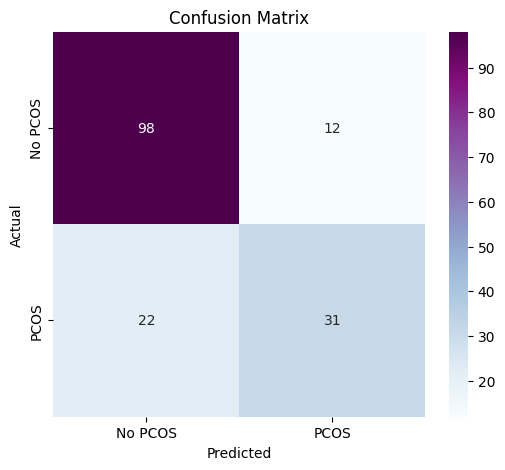

In [301]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='BuPu',
    xticklabels=['No PCOS', 'PCOS'],
    yticklabels=['No PCOS', 'PCOS']
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Feature Importance

               Feature  Importance
16             cluster    0.193776
13            amhng_ml    0.108550
9             lhmiu_ml    0.065646
2       hair_growthy_n    0.065340
14    i_beta_hcgmiu_ml    0.063113
10            prlng_ml    0.061955
8            fshmiu_ml    0.057882
1       weight_gainy_n    0.057213
11           tsh_miu_l    0.056507
3   skin_darkening_y_n    0.055297
0              age_yrs    0.051426
12            prgng_ml    0.045661
6        fast_food_y_n    0.036484
5           pimplesy_n    0.030447
15   ii_beta_hcgmiu_ml    0.027987
7      reg_exercisey_n    0.012090
4         hair_lossy_n    0.010625


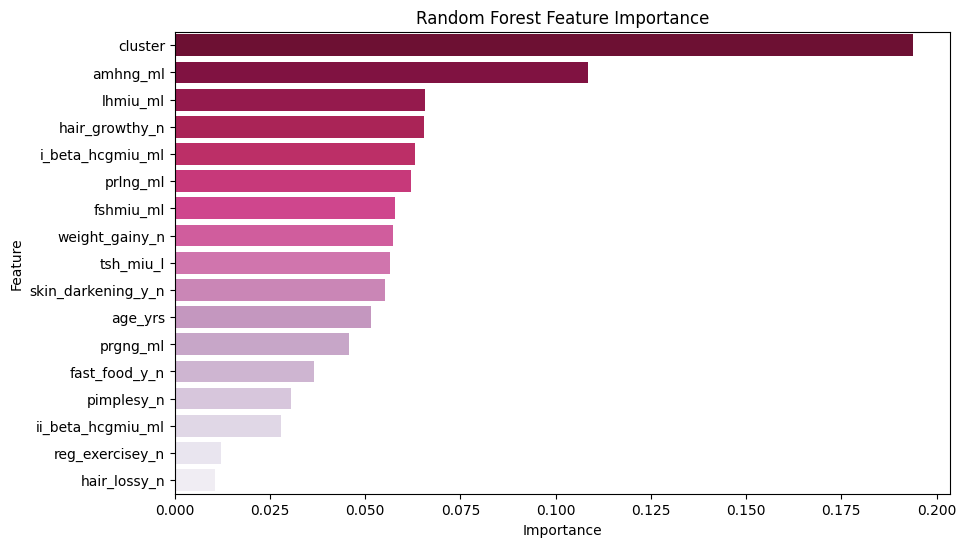

In [302]:
# Feature Importance

feat_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feat_importance)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance, hue='Feature', palette='PuRd_r', legend=False)
plt.title('Random Forest Feature Importance')
plt.show()



## Predicted Probabilities

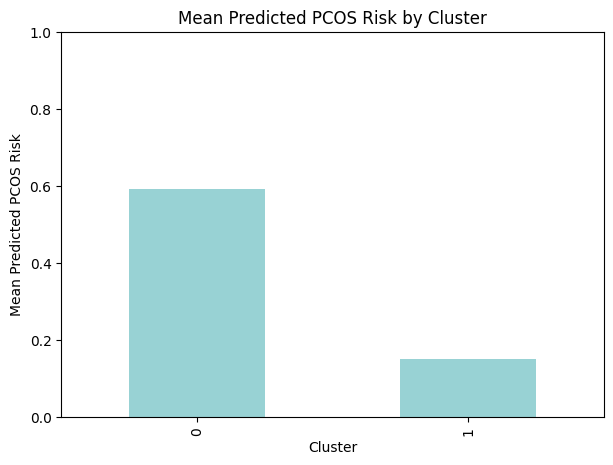

In [303]:
# Predicted probabilities

y_prob = rf.predict_proba(X_test)[:, 1]

df_probs = X_test.copy()
df_probs['actual_pcos'] = y_test.values
df_probs['predicted_risk'] = y_prob

# Add predicted probabilities to test set
y_proba = rf.predict_proba(X_test)[:, 1]

proba_df = X_test.copy()
proba_df['predicted_risk'] = y_proba
proba_df['actual_pcos'] = y_test.values

proba_df['cluster'] = df_clustered.loc[X_test.index, 'cluster']

# Compute mean predicted risk per cluster
mean_risk_by_cluster = proba_df.groupby('cluster')['predicted_risk'].mean()

# Bar plot
mean_risk_by_cluster.plot(kind='bar', color="#98D2D4", figsize=(7,5))
plt.xlabel("Cluster")
plt.ylabel("Mean Predicted PCOS Risk")
plt.title("Mean Predicted PCOS Risk by Cluster")
plt.ylim(0,1)  # Optional: risk is 0–1
plt.show()


## Error Analysis

In [304]:
# Total patients in test set
print(y_test.shape)

# Misclassified patients
print((y_test != y_pred).sum())

(163,)
34


In [305]:
# Identify misclassified samples

# Create a results DataFrame
results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = y_pred
results['predicted_risk'] = rf.predict_proba(X_test)[:, 1]

# Add cluster assignment
results['cluster'] = df_clustered.loc[X_test.index, 'cluster']

# Filter misclassified samples
misclassified = results[results['actual'] != results['predicted']]

print("Total misclassified samples:", len(misclassified))


Total misclassified samples: 34


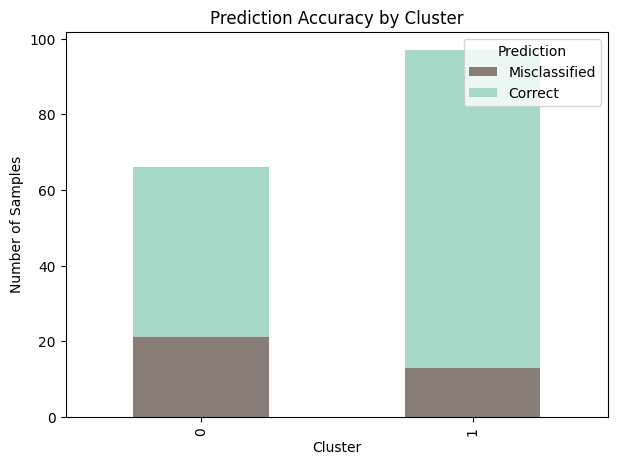

In [306]:
# Calculate counts of correct and incorrect predictions per cluster
error_counts = (
    results
    .assign(correct=results['actual'] == results['predicted'])
    .groupby('cluster')['correct']
    .value_counts()
    .unstack(fill_value=0)
)

# Rename columns for legend
error_counts.columns = ['Misclassified', 'Correct']

# Plot stacked bar
error_counts.plot(kind='bar', stacked=True, color=["#887D77", "#A7D8C7"], figsize=(7,5))
plt.ylabel("Number of Samples")
plt.xlabel("Cluster")
plt.title("Prediction Accuracy by Cluster")
plt.legend(title="Prediction", loc='upper right')
plt.show()


In [307]:
# Compare to class averages

# Compute class averages on training set
class_means = X_train.groupby(y_train).mean()

comparison_rows = []

for idx, row in misclassified.head(5).iterrows():
    true_class = row['actual']
    cluster = row['cluster']  # make sure 'cluster' is in misclassified dataframe
    diffs = row[feature_cols] - class_means.loc[true_class, feature_cols]
    
    # Get top 3 largest deviations with values
    top_diffs = diffs.abs().sort_values(ascending=False).head(3)
    top_features = top_diffs.index.tolist()
    top_values = [round(diffs[f], 3) for f in top_features]
    
    comparison_rows.append({
        "Sample Index": idx,
        "Cluster": cluster,
        "Actual PCOS": true_class,
        "Predicted PCOS": row['predicted'],
        "Top Deviating Features": top_features,
        "Deviation Values": top_values
    })

# Create DataFrame
error_analysis_table = pd.DataFrame(comparison_rows)

# Display table
from IPython.display import display
display(error_analysis_table)


,Sample Index,Cluster,Actual PCOS,Predicted PCOS,Top Deviating Features,Deviation Values
0,309,0,1,0.0,"[prlng_ml, age_yrs, i_beta_hcgmiu_ml]","[-14.018, -6.298, -2.734]"
1,401,0,0,1.0,"[fshmiu_ml, age_yrs, i_beta_hcgmiu_ml]","[-20.815, -4.024, -2.072]"
2,398,0,1,0.0,"[age_yrs, prlng_ml, ii_beta_hcgmiu_ml]","[5.702, -5.308, 2.878]"
3,380,0,0,1.0,"[fshmiu_ml, age_yrs, prlng_ml]","[-18.795, 4.976, -4.537]"
4,453,1,1,0.0,"[prlng_ml, age_yrs, i_beta_hcgmiu_ml]","[-10.948, 4.702, 3.029]"
